# About
This was used to produce Figure 5 and 6.

# Prereqs

In [1]:
import collections
import csv
import gzip
import pathlib
import time
import sys

In [2]:
from matplotlib import pyplot

In [3]:
sys.path.append('/galaxy/home/nick/code/nick-bfx')
import fastagenerators

In [4]:
%matplotlib inline

In [5]:
MAIN_DIR = pathlib.Path('/nfs/brubeck.bx.psu.edu/scratch4/nick/overlaps/auto/ecoli')
CSV_PATH = MAIN_DIR/'sra.runinfo3.csv.gz'
# The reference most frequently chosen as the best match for each run
REF_PATH = MAIN_DIR/'refs/individual/GCF_008761455.1_ASM876145v1_genomic.fna'
COLORS = collections.OrderedDict((('A','#3ab53a'), ('T','#d24343'), ('C','#3491d1'), ('G','#f68b2b')))
BASES = tuple(COLORS.keys())

## Misc

In [6]:
def matches_platform(runs, sample, platform):
  run = runs.get(sample)
  if not run:
    return False
  if platform == run.Model:
    return True
  abbrev = ' '.join(run.Model.split()[1:])
  if platform == abbrev:
    return True
  return False

In [7]:
def get_done_samples(done_file='seq-context.tsv', platform=None, runs=None, main_dir=MAIN_DIR):
  if (platform and not runs) or (runs and not platform):
    raise ValueError(f'Must provide both platform and runinfos, or neither.')
  for sample_dir in (main_dir/'runs').iterdir():
    sample = sample_dir.name
    context_path = sample_dir/done_file
    if not context_path.is_file():
      continue
    if (platform and runs) and not matches_platform(runs, sample, platform):
      continue
    yield sample

In [8]:
def human_time(sec):
  if sec < 60:
    return format_time(sec, 'second')
  elif sec < 60*60:
    return format_time(sec/60, 'minute')
  elif sec < 24*60*60:
    return format_time(sec/60/60, 'hour')
  elif sec < 10*24*60*60:
    return format_time(sec/60/60/24, 'day')
  elif sec < 40*24*60*60:
    return format_time(sec/60/60/24/7, 'week')
  elif sec < 365*24*60*60:
    return format_time(sec/60/60/24/30.5, 'month')
  else:
    return format_time(sec/60/60/24/365, 'year')
def format_time(quantity, unit):
  rounded = round(quantity, 1)
  if rounded == int(quantity):
    rounded = int(quantity)
  output = str(rounded)+' '+unit
  if rounded != 1:
    output += 's'
  return output

## Reading metadata

In [9]:
def read_runinfo(csv_path):
  start = time.perf_counter()
  int_fields = {'spots', 'spots_with_mates', 'avgLength', 'size_MB', 'InsertSize', 'InsertDev', 'ProjectID', 'TaxID'}
  runs = {}
  header = {}
  empty_lines = 0
  header_lines = 0
  try:
    with gzip.open(csv_path, 'rt') as csv_file:
      for row in csv.reader(csv_file):
        if not header:
          header_lines += 1
          for i, value in enumerate(row):
            header[i] = value
          RunInfo = collections.namedtuple('RunInfo', header.values())
          continue
        if len(row) == 0:
          empty_lines += 1
          continue
        assert len(row) == len(header), (len(row), row)
        header_matches = 0
        value_dict = {}
        for i, raw_value in enumerate(row):
          if raw_value == header[i]:
            header_matches += 1
          else:
            if header[i] in int_fields:
              try:
                value = int(raw_value)
              except ValueError:
                if header[i] == 'InsertDev':
                  value = float(raw_value)
                else:
                  print(f'{header[i]}: {raw_value!r}', file=sys.stderr)
            else:
              value = raw_value
          value_dict[header[i]] = value
        if header_matches > 5:
          header_lines += 1
          continue
        runs[value_dict['Run']] = RunInfo(**value_dict)
  except EOFError:
    print('Incomplete gzip.', file=sys.stderr)
  elapsed = time.perf_counter() - start
  print(f'{len(runs)} runs in {elapsed:0.1f} seconds (headers: {header_lines}, empty lines: {empty_lines})')
  return runs

## Read in the metadata

In [10]:
RUNS = read_runinfo(CSV_PATH)

186022 runs in 11.9 seconds (headers: 1, empty lines: 0)


## Analyzing reference

In [11]:
def count_homopolymers(ref_path, limit=None):
  run_counts = collections.defaultdict(collections.Counter)
  for sequence in fastagenerators.FastaLineBuffered(ref_path):
    run_len = 0
    run_base = None
    for coord, base in enumerate(sequence.bases(), 1):
      if base == run_base:
        run_len += 1
      else:
        # Save the previous homopolymer
        if run_base:
          run_counts[run_base][run_len] += 1
        run_base = base
        run_len = 1
      if limit and coord >= limit:
        break
    if run_base:
      run_counts[run_base][run_len] += 1
  return dict(run_counts)

In [12]:
def get_genome_size(run_counts):
  total_bases = 0
  for base, base_hpol_counts in run_counts.items():
    for run_len, count in base_hpol_counts.items():
      total_bases += run_len*count
  return total_bases

## Analyze the reference

In [13]:
RUN_COUNTS = count_homopolymers(REF_PATH)
get_genome_size(RUN_COUNTS)

5264517

## Data import

In [14]:
def get_null_or_value(raw_value, null_str='.', type=str):
  if raw_value == null_str:
    return None
  else:
    return type(raw_value)
def read_post_homopol_counts(counts_path):
  hpol_counts = {}
  with counts_path.open() as counts_file:
    for line_raw in counts_file:
      fields = line_raw.rstrip('\r\n').split('\t')
      error_base = get_null_or_value(fields[0])
      run_len = get_null_or_value(fields[1], type=int)
      count = get_null_or_value(fields[2], type=int)
      if error_base not in hpol_counts:
        hpol_counts[error_base] = {}
      if run_len not in hpol_counts[error_base]:
        hpol_counts[error_base][run_len] = {}
      hpol_counts[error_base][run_len] = count
  return hpol_counts

In [15]:
def update_hpol_counts(hpol_counts, new_counts):
  for base, new_base_counts in new_counts.items():
    base_counts = hpol_counts.setdefault(base, {})
    for run_len, count in new_base_counts.items():
      old_count = base_counts.get(run_len, 0)
      base_counts[run_len] = old_count + count

In [16]:
def get_platform_counts(platform, runs=RUNS, main_dir=MAIN_DIR):
  print(f'Processing {platform}:')
  start = last = time.perf_counter()
  hpol_counts = collections.defaultdict(collections.Counter)
  num_samples = 0
  for sample in get_done_samples(done_file='post-homopols.tsv', platform=platform, runs=runs):
    sample_counts = read_post_homopol_counts(main_dir/'runs'/sample/'post-homopols.tsv')
    update_hpol_counts(hpol_counts, sample_counts)
    num_samples += 1
    now = time.perf_counter()
    if now - last > 5*60:
      print(f'  Done with {num_samples:>3d} samples after {human_time(now-start)}..')
      last = now
  elapsed = time.perf_counter() - start
  print(f'Finished: {num_samples:>3d} samples in {human_time(elapsed)}')
  return hpol_counts

In [17]:
herror_counts = {}
for platform in ('MiSeq', 'MiniSeq', 'NextSeq 500', 'NextSeq 550', 'HiSeq 2500', 'NovaSeq 6000', 'HiSeq X Ten'):
  herror_counts[platform] = get_platform_counts(platform)

Processing MiSeq:
Finished: 299 samples in 23.2 seconds
Processing MiniSeq:
Finished:  69 samples in 15.5 seconds
Processing NextSeq 500:
Finished: 267 samples in 20.3 seconds
Processing NextSeq 550:
Finished: 282 samples in 16.9 seconds
Processing HiSeq 2500:
Finished: 273 samples in 18.2 seconds
Processing NovaSeq 6000:
Finished: 344 samples in 16.8 seconds
Processing HiSeq X Ten:
Finished: 295 samples in 19.8 seconds


## What are the normalized counts of post-homopolymer errors?

In [18]:
def get_total_errors(herr_plat_counts):
  total_errors = 0
  for base, base_err_counts in herr_plat_counts.items():
    if base in ('N', None):
      continue
    total_errors += sum(base_err_counts.values())
  return total_errors

In [19]:
def get_ratios_norm2(herr_plat_counts, run_counts, base, thres=0):
  run_lens = []
  ratios = []
  total_errors = get_total_errors(herr_plat_counts)
  genome_size = get_genome_size(run_counts)
  for run_len, error_count in herr_plat_counts[base].items():
    hpol_count = run_counts[base][run_len]
    if hpol_count <= thres:
      continue
    # How many post-homopol errors would we see if there were no association between homopolymers and errors?
    # If errors were distributed randomly, then by coincidence a given error would have a
    # `hpol_count/genome_size` chance of landing at the end of a homopolymer. Then a quarter of the errors
    # would be the same base as the homopolymer.
    expected_errors = total_errors * hpol_count/genome_size/4
#     print(base, run_len, error_count, hpol_count, error_count/hpol_count, sep='\t')
    run_lens.append(run_len)
    ratios.append(error_count/expected_errors)
  return run_lens, ratios

### Normalized by expected number of errors for that homopolymer type

Text(0.09, 0.5, 'Post-homopolymer error overrepresentation')

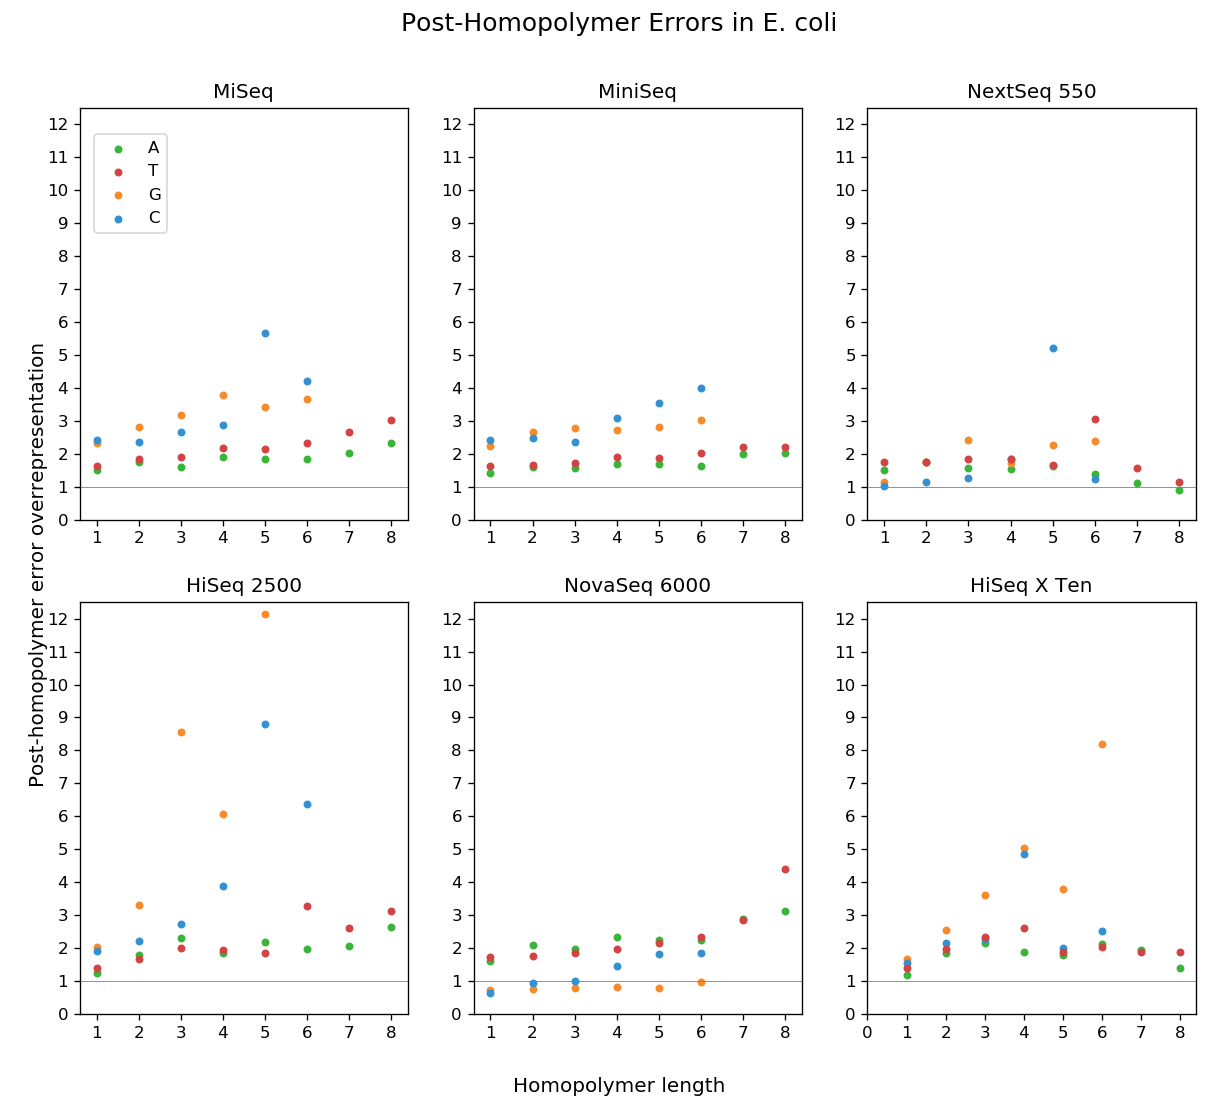

In [20]:
platforms = ('MiSeq', 'MiniSeq', 'NextSeq 550', 'HiSeq 2500', 'NovaSeq 6000', 'HiSeq X Ten')
max_y = 12.5
figure = pyplot.figure(dpi=120, figsize=(12,10))
first_axes = None
max_x = 0
for i, platform in enumerate(platforms):
  platform_error_counts = herror_counts[platform]
  if first_axes is None:
    first_axes = axes = figure.add_subplot(2,3,i+1)
  else:
    axes = figure.add_subplot(2,3,i+1, sharex=first_axes, sharey=first_axes)
  points = {}
  for base, base_run_counts in RUN_COUNTS.items():
    run_lens, ratios = get_ratios_norm2(platform_error_counts, RUN_COUNTS, base, thres=100)
    points[base] = axes.scatter(run_lens, ratios, s=14, c=COLORS[base])
    max_x = max(max_x, max(run_lens))
  axes.set_xticks(range(max_x+1))
  axes.set_yticks(range(round(max_y)+1))
  axes.set_ylim(bottom=0, top=max_y)
  axes.axhline(y=1, color='gray', linewidth=0.5)
  axes.set_title(platform)
labels = 'ATGC'
points_list = [points[base] for base in labels]
figure.legend(points_list, labels, loc=(0.078, 0.79))
figure.suptitle('Post-Homopolymer Errors in E. coli', y=0.96, fontsize=15)
figure.text(0.5, 0.06, 'Homopolymer length', fontsize=12, horizontalalignment='center')
figure.text(
  0.09, 0.5, 'Post-homopolymer error overrepresentation', fontsize=12, verticalalignment='center', rotation=90
)

# What proportion of errors are post-homopolymer ones?

In [21]:
for herr_plat_counts in herror_counts.values():
  for base, herr_base_counts in list(herr_plat_counts.items()):
    if not herr_base_counts:
      del herr_plat_counts[base]

In [22]:
def get_total_hpols(herror_counts, thres):
  total = 0
  for run_len, count in herror_counts.items():
    if run_len is not None and run_len >= thres:
      total += count
  return total

In [23]:
def get_hpol_pcts(platform_error_counts, canonical='ACGT'):
  platform_pcts = {}
  for base, herr_base_counts in platform_error_counts.items():
    if base is None or base not in canonical:
      continue
    threses = []
    pcts = []
    total_errors = sum(herr_base_counts.values())
    for run_len, herr_run_counts in herr_base_counts.items():
      if run_len is None or run_len < 2:
        continue
      hpols = get_total_hpols(herr_base_counts, run_len)
      threses.append(run_len)
      pcts.append(100*hpols/total_errors)
    platform_pcts[base] = (threses, pcts)
  return platform_pcts

Text(0.075, 0.5, 'Percent of all errors')

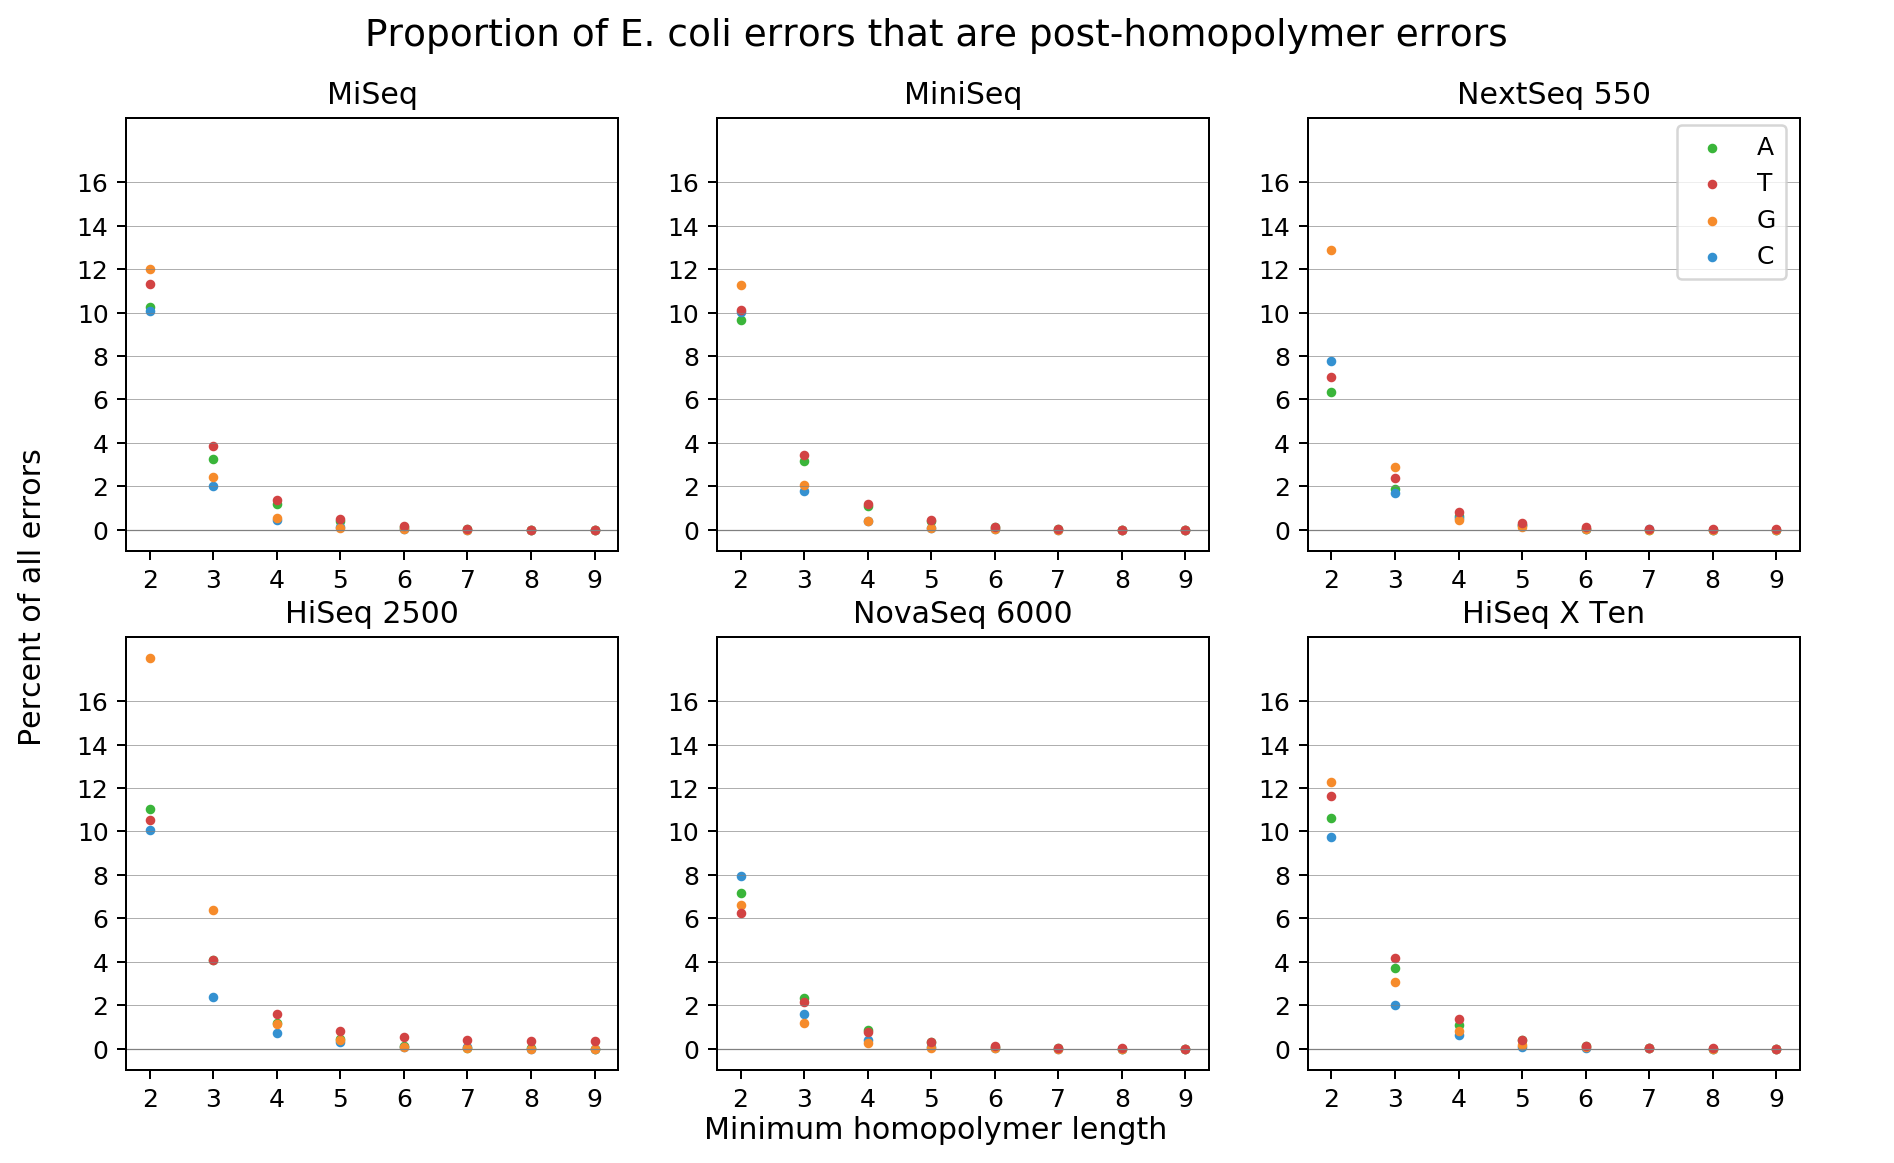

In [24]:
platforms = ('MiSeq', 'MiniSeq', 'NextSeq 550', 'HiSeq 2500', 'NovaSeq 6000', 'HiSeq X Ten')
figure = pyplot.figure(dpi=180, figsize=(12,7))
first_axes = None
for i, platform in enumerate(platforms):
  platform_error_counts = herror_counts[platform]
  if first_axes is None:
    first_axes = axes = figure.add_subplot(2,3,i+1)
  else:
    axes = figure.add_subplot(2,3,i+1, sharex=first_axes, sharey=first_axes)
  points = {}
  platform_pcts = get_hpol_pcts(platform_error_counts)
  for base, (threses, pcts) in platform_pcts.items():
    points[base] = axes.scatter(threses, pcts, s=8, c=COLORS[base])
  yticks = []
  ylabels = []
  for y in range(0, 18, 2):
    yticks.append(y)
    ylabels.append(y)
    if y == 0:
      width = 0.5
    else:
      width = 0.25
    axes.axhline(y=y, color='gray', linewidth=width)
  axes.set_yticks(yticks)
  axes.set_yticklabels(ylabels)
  axes.set_xticks(list(range(2,10)))
  axes.set_title(platform)
#   axes.set_yscale('log')
labels = 'ATGC'
points_list = [points[base] for base in labels]
figure.legend(points_list, labels, loc=(0.885, 0.76))
figure.suptitle('Proportion of E. coli errors that are post-homopolymer errors', y=0.96, fontsize=15)
figure.text(0.5, 0.07, 'Minimum homopolymer length', fontsize=12, horizontalalignment='center')
figure.text(0.075, 0.5, 'Percent of all errors', fontsize=12, verticalalignment='center', rotation=90)